# determine differences among two mobile plans

In this project, I will carry out a preliminary analysis for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

This analysis of the plans, is based on a relatively small client selection: the data on 500 Megaline clients describe who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Initialization

Loading all the libraries


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np    
import seaborn as sns
import math
from scipy import stats as st


## Load data

Load the data files into different DataFrames

In [2]:


try:
    
    calls=pd.read_csv('megaline_calls.csv',sep=',')
    internet=pd.read_csv('megaline_internet.csv',sep=',')
    messages=pd.read_csv('megaline_messages.csv',sep=',')
    plans=pd.read_csv('megaline_plans.csv',sep=',')
    users=pd.read_csv('megaline_users.csv',sep=',')

except:
    calls=pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/megaline_calls.csv',sep=',')
    internet=pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/megaline_internet.csv',sep=',')
    messages=pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/megaline_messages.csv',sep=',')
    plans=pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/megaline_plans.csv',sep=',')
    users=pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/megaline_users.csv',sep=',')



## Prepare the data

At this stage, the data is split into several tables. Let's explore each one to get an initial understanding of the data and do necessary corrections to each table if necessary.

In [3]:
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


The ***calls*** table (data on calls):
* *id* — unique call identifier
* *call_date* — call date
* *duration* — call duration (in minutes)
* *user_id* — the identifier of the user making the call

One of the first steps when exploring a new data set is making sure the data types are set correctly. To allow further manipulation without getting unexpected results or errors, it's important to convert data from one type to another. So we neend to convert dates from objrct data type, to datetime data type.

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format= '%Y/%m/%d')

Megaline rounds seconds up to minutes when they count the extra time to charge.

In [5]:
calls['duration_ceil'] = calls['duration'].apply(np.ceil).astype(int)

In [6]:
calls.head()

,id,user_id,call_date,duration,duration_ceil
0,1000_93,1000,2018-12-27,8.52,9
1,1000_145,1000,2018-12-27,13.66,14
2,1000_247,1000,2018-12-27,14.48,15
3,1000_309,1000,2018-12-28,5.76,6
4,1000_380,1000,2018-12-30,4.22,5


In [7]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             137735 non-null  object        
 1   user_id        137735 non-null  int64         
 2   call_date      137735 non-null  datetime64[ns]
 3   duration       137735 non-null  float64       
 4   duration_ceil  137735 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(1)
memory usage: 4.7+ MB


In [8]:
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


The ***internet table*** (data on web sessions):
* *id* — unique session identifier
* *mb_used* — the volume of data spent during the session (in megabytes)
* *session_date* — web session date
* *user_id* — user identifier

In [9]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


The ***plans table*** (data on the plans):
* *plan_name* — calling plan name
* *usd_monthly_fee* — monthly charge in US dollars
* *minutes_included* — monthly minute allowance
* *messages_included* — monthly text allowance
* *mb_per_month_included* — data volume allowance (in megabytes)
* *usd_per_minute* — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st * minute will be charged)
* *usd_per_message* — price per text after exceeding the package limits
* *usd_per_gb* — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


The **messages table** (data on texts):
* *id* — unique text message identifier
* *message_date* — text message date
* *user_id* — the identifier of the user sending the text

In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


The **users table** (data on users):
* *user_id* — unique user identifier
* *first_name* — user's name
* *last_name* — user's last name
* *age* — user's age (years)
* *reg_date* — subscription date (dd, mm, yy)
* *churn_date* — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
* *city* — user's city of residence
* *plan* — calling plan name

## Plans

Print the general/summary informations and a sample of data for plans:

In [12]:

plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [13]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


This set of data seems appropriate, I will just perform a correction by adding a useful column:

## Fix data and enrich data

At Megaline, for web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

I am going to add a column about the amount of gigabyte offered by each plan: the original dataset has a colum describing the megabyte, but is not  very useful, indeed we will calculate the revenue for each plans based on the total amount of Giga (rounded up) used by each user.

In [14]:
plans['gb_per_month_included']=plans['mb_per_month_included']*0.001
plans['gb_per_month_included'] = plans['gb_per_month_included'].apply(np.floor).astype(int)

In [15]:
plans.T

,0,1
messages_included,50,1000
mb_per_month_included,15360,30720
minutes_included,500,3000
usd_monthly_pay,20,70
usd_per_gb,10,7
usd_per_message,0.03,0.01
usd_per_minute,0.03,0.01
plan_name,surf,ultimate
gb_per_month_included,15,30


In [16]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
 8   gb_per_month_included  2 non-null      int32  
dtypes: float64(2), int32(1), int64(5), object(1)
memory usage: 264.0+ bytes


## Users

 Print the general/summary information about the users DataFrame

In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Print a sample of data for users

In [18]:
users.sample(20)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
156,1156,Anette,Chambers,71,"Albuquerque, NM MSA",2018-03-25,surf,NaN
183,1183,Jermaine,Gallegos,71,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-07-20,surf,NaN
91,1091,Taylor,Oliver,38,"Riverside-San Bernardino-Ontario, CA MSA",2018-05-04,ultimate,NaN
229,1229,Augustus,Barker,69,"Austin-Round Rock-Georgetown, TX MSA",2018-12-09,ultimate,NaN
127,1127,Marchelle,Brock,28,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-23,surf,NaN
387,1387,Raymonde,Lowe,28,"Bridgeport-Stamford-Norwalk, CT MSA",2018-05-25,surf,NaN
41,1041,Drucilla,Lynn,58,"Las Vegas-Henderson-Paradise, NV MSA",2018-03-17,ultimate,NaN
262,1262,Michelina,Hamilton,34,"Dallas-Fort Worth-Arlington, TX MSA",2018-02-09,surf,NaN
468,1468,Johana,Kim,55,"Denver-Aurora-Lakewood, CO MSA",2018-09-08,surf,NaN
39,1039,Flo,Hicks,56,"Columbus, OH MSA",2018-05-30,ultimate,NaN


In [19]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,45.486,16.972269,18.0,30.00,46.0,61.00,75.0


change data type of users id from int to category: a signal to other Python libraries that this column should be treated as a categorical variable (e.g. to use suitable statistical methods or plot types).

In [20]:
users['user_id']=users['user_id'].astype('category')

In [21]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   user_id     500 non-null    category
 1   first_name  500 non-null    object  
 2   last_name   500 non-null    object  
 3   age         500 non-null    int64   
 4   city        500 non-null    object  
 5   reg_date    500 non-null    object  
 6   plan        500 non-null    object  
 7   churn_date  34 non-null     object  
dtypes: category(1), int64(1), object(6)
memory usage: 48.5+ KB


### Fix Data

converting registration date to datetime data type:

In [22]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y/%m/%d')

In [23]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y/%m/%d')

fill the missing values in churn date with "unknown", since I don't have enough information to perform a substitution based on others parameters:

In [24]:
users['churn_date']=users['churn_date'].fillna('unknown')

In [25]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    category      
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    object        
dtypes: category(1), datetime64[ns](1), int64(1), object(5)
memory usage: 48.5+ KB


by filling with unknown, the data type went back to object. I will not use this column,the data is corrupted: too many unknown.

In [26]:
users.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
258,1258,Kai,Russell,39,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-07-12,surf,unknown
423,1423,Malcom,Neal,61,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-10-16,surf,unknown
466,1466,Alphonse,Harmon,56,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-01-26,surf,2018-09-17 00:00:00
75,1075,Salena,Bates,35,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-08-06,surf,unknown
228,1228,Jude,Hale,26,"Detroit-Warren-Dearborn, MI MSA",2018-04-15,surf,unknown
61,1061,Maryam,Valencia,38,"Columbia, SC MSA",2018-03-08,ultimate,unknown
138,1138,Arlie,Higgins,66,"Riverside-San Bernardino-Ontario, CA MSA",2018-02-06,surf,unknown
434,1434,Kai,Barr,18,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-03-06,surf,unknown
361,1361,Jacelyn,Hoffman,45,"Birmingham-Hoover, AL MSA",2018-04-14,surf,unknown
369,1369,Bernard,Mckee,69,"Milwaukee-Waukesha, WI MSA",2018-10-06,surf,unknown


to facilitate further steps, we can convert all cases to lowercase:

In [27]:
def lower_consistent(df):
    '''defining a function to convert all strings to lowercase, 
       making it general with the condition of data type=object,  
       to possibly apply it in future manipulation''' 
    
    df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x) 
    return df



In [28]:
users[['first_name', 'last_name', 'city']] = lower_consistent(users[['first_name', 'last_name', 'city']])


In [29]:
users.sample(3)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
176,1176,terrance,shaffer,75,"new york-newark-jersey city, ny-nj-pa msa",2018-10-03,surf,unknown
142,1142,charlesetta,dillard,18,"new orleans-metairie, la msa",2018-08-23,surf,unknown
440,1440,france,barrett,49,"nashville-davidson–murfreesboro–franklin, tn msa",2018-04-16,surf,unknown


looking for duplicates:

In [30]:
users.duplicated().value_counts()

False    500
dtype: int64

In [31]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    category      
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    object        
dtypes: category(1), datetime64[ns](1), int64(1), object(5)
memory usage: 48.5+ KB


No duplicated rows were found.

## Calls

Print the general/summary information about the calls' DataFrame

In [32]:

calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             137735 non-null  object        
 1   user_id        137735 non-null  int64         
 2   call_date      137735 non-null  datetime64[ns]
 3   duration       137735 non-null  float64       
 4   duration_ceil  137735 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(1)
memory usage: 4.7+ MB


Print a sample of data for calls

In [33]:
calls.sample(15)

,id,user_id,call_date,duration,duration_ceil
78262,1280_292,1280,2018-09-30,4.58,5
17539,1067_57,1067,2018-11-06,18.96,19
57943,1209_439,1209,2018-12-27,2.05,3
135664,1491_635,1491,2018-09-18,13.71,14
16482,1064_340,1064,2018-12-16,13.19,14
136846,1496_15,1496,2018-10-03,3.49,4
90772,1328_402,1328,2018-05-14,0.00,0
10862,1049_29,1049,2018-05-26,6.96,7
85689,1314_116,1314,2018-11-05,11.18,12
11946,1052_165,1052,2018-12-30,10.32,11


user Id need to be converted to category,in a previous step, we added call duration round up

In [34]:
calls.duplicated().value_counts()

False    137735
dtype: int64

### Fix data

converting type:

In [35]:
calls['user_id']=calls['user_id'].astype('category')

### Enrich data

Extracting the month from each call date and adding it to a new colum: we'll use it to find statistical data for each month

In [36]:
calls['month'] = pd.to_datetime(calls['call_date']).dt.month

In [37]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             137735 non-null  object        
 1   user_id        137735 non-null  category      
 2   call_date      137735 non-null  datetime64[ns]
 3   duration       137735 non-null  float64       
 4   duration_ceil  137735 non-null  int32         
 5   month          137735 non-null  int64         
dtypes: category(1), datetime64[ns](1), float64(1), int32(1), int64(1), object(1)
memory usage: 5.0+ MB


finding the total amount of calls for each month:

In [38]:
calls.month.value_counts()

12    30614
11    24651
10    21064
9     16523
8     13590
7     11105
6      8221
5      5959
4      3442
3      1620
2       774
1       172
Name: month, dtype: int64

This information will not assist us in the analysis, since the additonal charges will not be counted by number of phone calls, but by minutes used. **Anyway this information gives us a preview of the general distribution of the user's behaviour, we should expect some similar outcome when analyzing other parameters, like minutes: we can clearly see a steady ascending amount of calls from January to December**. This is probably due to an increased amount of subscriptions during the Year.


Let's check when the clients registered:

In [39]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    category      
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    object        
dtypes: category(1), datetime64[ns](1), int64(1), object(5)
memory usage: 48.5+ KB


In [40]:
users['reg_month'] = pd.to_datetime(users['reg_date']).dt.month

In [41]:
users.reg_month.value_counts()

6     54
1     49
8     47
4     45
10    42
2     42
3     40
5     38
11    38
12    37
7     36
9     32
Name: reg_month, dtype: int64

the increased amount of calls from jan to dec is not due to an increased amount of subscriptions, there must be some other reason. 

In [42]:
calls.duplicated().value_counts()

False    137735
dtype: int64

no duplicated  rows were found

## Messages

Print the general/summary information about the messages' DataFrame


In [43]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [44]:

messages.sample(6)

,id,user_id,message_date
71041,1462_149,1462,2018-12-03
1050,1011_13,1011,2018-12-21
56533,1357_163,1357,2018-07-08
36354,1242_26,1242,2018-10-11
58125,1366_1,1366,2018-09-27
10301,1076_685,1076,2018-08-19


In [45]:
messages.duplicated().value_counts()

False    76051
dtype: int64

no duplicated rows were found

### Fix data

changing data types:

In [46]:
messages['user_id']=calls['user_id'].astype('category')

In [47]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y/%m/%d')

### Enrich data

adding column for months:

In [48]:
messages['month'] = pd.to_datetime(messages['message_date']).dt.month

In [49]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  category      
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(1), object(1)
memory usage: 1.9+ MB


In [50]:
messages.sample(6)

,id,user_id,message_date,month
75256,1491_15,1266,2018-09-29,9
46494,1316_388,1168,2018-10-15,10
3679,1038_32,1014,2018-12-17,12
15369,1101_426,1061,2018-09-30,9
8818,1065_89,1041,2018-09-28,9
65778,1424_91,1237,2018-12-28,12


In [51]:
messages.month.value_counts()

12    19071
11    14068
10    12201
9      9227
8      7394
7      5208
6      3833
5      2780
4      1333
3       594
2       259
1        83
Name: month, dtype: int64

It's possible to notice a distribution of messages sent by month similar to the number of calls

## Internet

Print the general/summary information about the internet DataFrame and a sample:

In [52]:
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [53]:
internet.sample(10)

,id,user_id,session_date,mb_used
8031,1043_91,1043,2018-07-15,275.14
9020,1046_305,1046,2018-10-16,232.11
3494,1020_41,1020,2018-12-25,333.74
46847,1209_58,1209,2018-12-30,732.70
55548,1251_359,1251,2018-07-29,208.16
34203,1155_247,1155,2018-04-17,739.85
53600,1242_11,1242,2018-10-10,378.44
17025,1077_145,1077,2018-11-02,601.24
74157,1347_252,1347,2018-10-29,269.61
93711,1437_424,1437,2018-12-17,164.60


It's better to convert the data about internet sessions to gb, to comply with the rounding rules that Megaline apply to the customers

### Fix data

converting data type:

In [54]:
internet['user_id']=internet['user_id'].astype('category')

### Enrich data

adding a month column:

In [55]:
internet['month'] = pd.to_datetime(internet['session_date']).dt.month


In [56]:
internet.sample(6)

,id,user_id,session_date,mb_used,month
24680,1113_329,1113,2018-07-26,73.83,7
83063,1387_279,1387,2018-08-27,436.73,8
77516,1362_188,1362,2018-10-19,0.00,10
9855,1050_276,1050,2018-04-10,329.83,4
67924,1316_176,1316,2018-11-02,1068.44,11
44133,1196_135,1196,2018-03-26,390.54,3


adding a column of Gb used:

In [57]:
internet['gb_used']=internet['mb_used']*0.001


In [58]:
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [59]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  category      
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
 5   gb_used       104825 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 4.2+ MB


In [60]:
internet.describe()

,mb_used,month,gb_used
count,104825.000000,104825.000000,104825.000000
mean,366.713701,9.342552,0.366714
std,277.170542,2.400404,0.277171
min,0.000000,1.000000,0.000000
25%,136.080000,8.000000,0.136080
50%,343.980000,10.000000,0.343980
75%,554.610000,11.000000,0.554610
max,1693.470000,12.000000,1.693470


## Study plan conditions

It is critical to understand how the plans work, how users are charged based on their plan subscription. So, let's print out the plan information to view their conditions once again.

In [61]:


plans.T

,0,1
messages_included,50,1000
mb_per_month_included,15360,30720
minutes_included,500,3000
usd_monthly_pay,20,70
usd_per_gb,10,7
usd_per_message,0.03,0.01
usd_per_minute,0.03,0.01
plan_name,surf,ultimate
gb_per_month_included,15,30


## Aggregate data per user

Now, as the data is clean, aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.

In [62]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             137735 non-null  object        
 1   user_id        137735 non-null  category      
 2   call_date      137735 non-null  datetime64[ns]
 3   duration       137735 non-null  float64       
 4   duration_ceil  137735 non-null  int32         
 5   month          137735 non-null  int64         
dtypes: category(1), datetime64[ns](1), float64(1), int32(1), int64(1), object(1)
memory usage: 5.0+ MB


In [63]:
calls.head(3)

,id,user_id,call_date,duration,duration_ceil,month
0,1000_93,1000,2018-12-27,8.52,9,12
1,1000_145,1000,2018-12-27,13.66,14,12
2,1000_247,1000,2018-12-27,14.48,15,12


calculate number of calls per month:

In [64]:
calls_month= calls.groupby(['user_id','month'])['month'].agg(calls_per_month='count')
calls_month.tail(20)


calls_per_month
user_id month                 
1498    5                   35
        6                   37
        7                   43
        8                   44
        9                   45
        10                  46
        11                  41
        12                  39
1499    1                    0
        2                    0
        3                    0
        4                    0
        5                    0
        6                    0
        7                    0
        8                    0
        9                   41
        10                  53
        11                  45
        12                  65

 Calculate the amount of minutes spent by each user per month. 

In [65]:
minutes_month=calls.groupby(['user_id','month']).agg('sum')
print(minutes_month.tail(20))
minutes_month.info()

               duration  duration_ceil
user_id month                         
1498    5        275.13            288
        6        225.57            238
        7        304.49            321
        8        244.57            266
        9        344.62            363
        10       278.06            298
        11       208.99            223
        12       324.77            339
1499    1          0.00              0
        2          0.00              0
        3          0.00              0
        4          0.00              0
        5          0.00              0
        6          0.00              0
        7          0.00              0
        8          0.00              0
        9        330.37            346
        10       363.28            385
        11       288.56            308
        12       468.10            496
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5772 entries, (1000, 1) to (1499, 12)
Data columns (total 2 columns):
 #   Column         No

same for messages:

In [66]:
messages.info()
messages.tail(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  category      
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(1), object(1)
memory usage: 1.9+ MB


,id,user_id,message_date,month
76031,1497_402,1268,2018-12-24,12
76032,1497_407,1268,2018-12-14,12
76033,1497_418,1268,2018-12-27,12
76034,1497_420,1268,2018-12-15,12
76035,1497_453,1268,2018-12-27,12
76036,1497_463,1268,2018-12-20,12
76037,1497_470,1268,2018-12-23,12
76038,1497_480,1268,2018-12-29,12
76039,1497_486,1268,2018-12-17,12
76040,1497_497,1268,2018-12-14,12


Calculate the number of messages sent by each user per month

In [67]:
messages_month=messages.groupby(['user_id','month'])['month'].agg(messages_per_month='count')
messages_month.sample(20)

,,messages_per_month
user_id,month,
1075,6,16
1004,1,0
1054,5,32
1048,6,8
1200,6,0
1193,11,59
1040,12,6
1017,5,0
1476,8,0


verify that it worked, by selecting one user:

In [68]:
messages.query('user_id==1038 and month==6')

,id,user_id,message_date,month
7995,1061_1,1038,2018-06-13,6
8009,1061_15,1038,2018-06-04,6
8024,1061_30,1038,2018-06-23,6
8028,1061_34,1038,2018-06-27,6
8031,1061_37,1038,2018-06-09,6
8047,1061_53,1038,2018-06-30,6
8051,1061_57,1038,2018-06-21,6


it worked, we can randomly check with other users as well.

Calculate the volume of internet traffic used by each user per month:

In [69]:
internet_month=internet.groupby(['user_id','month']).agg('sum')
print(internet_month.tail(20))
internet_month.info()

                mb_used   gb_used
user_id month                    
1498    5      22462.17  22.46217
        6      14807.18  14.80718
        7      24834.37  24.83437
        8      20261.89  20.26189
        9      22827.28  22.82728
        10     20580.76  20.58076
        11     19168.55  19.16855
        12     23137.69  23.13769
1499    1          0.00   0.00000
        2          0.00   0.00000
        3          0.00   0.00000
        4          0.00   0.00000
        5          0.00   0.00000
        6          0.00   0.00000
        7          0.00   0.00000
        8          0.00   0.00000
        9      12984.76  12.98476
        10     19492.43  19.49243
        11     16813.83  16.81383
        12     22059.21  22.05921
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5868 entries, (1000, 1) to (1499, 12)
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mb_used  5868 non-null   float64
 1   gb_used  5868

In [70]:
internet_month['gb_used'] = np.ceil(internet_month['gb_used'])

In [71]:
print(internet_month.tail(20))

                mb_used  gb_used
user_id month                   
1498    5      22462.17     23.0
        6      14807.18     15.0
        7      24834.37     25.0
        8      20261.89     21.0
        9      22827.28     23.0
        10     20580.76     21.0
        11     19168.55     20.0
        12     23137.69     24.0
1499    1          0.00      0.0
        2          0.00      0.0
        3          0.00      0.0
        4          0.00      0.0
        5          0.00      0.0
        6          0.00      0.0
        7          0.00      0.0
        8          0.00      0.0
        9      12984.76     13.0
        10     19492.43     20.0
        11     16813.83     17.0
        12     22059.21     23.0


Merge the data for  minutes, messages, internet based on user_id and month:

In [72]:

df2 = pd.merge(messages_month, minutes_month, how='left', left_index = True, right_index = True)
df3= pd.merge(df2, internet_month, how='left', left_index = True, right_index = True)



In [73]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5772 entries, (1000, 1) to (1499, 12)
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   messages_per_month  5772 non-null   int64  
 1   duration            5772 non-null   float64
 2   duration_ceil       5772 non-null   int32  
 3   mb_used             5760 non-null   float64
 4   gb_used             5760 non-null   float64
dtypes: float64(3), int32(1), int64(1)
memory usage: 380.4 KB


In [74]:
df3.sample(10)

,,messages_per_month,duration,duration_ceil,mb_used,gb_used
user_id,month,,,,,
1313,4,0,0.00,0,0.00,0.0
1474,7,0,0.00,0,0.00,0.0
1101,6,42,428.84,458,14432.43,15.0
1019,10,7,0.00,0,0.00,0.0
1114,11,95,623.69,663,26829.87,27.0
1297,10,0,0.00,0,0.00,0.0
1168,4,0,0.00,0,0.00,0.0
1446,7,0,0.00,0,0.00,0.0
1453,8,0,0.00,0,0.00,0.0


In [75]:
df3.head(20)

messages_per_month  duration  duration_ceil  mb_used  gb_used
user_id month                                                               
1000    1                       0      0.00              0     0.00      0.0
        2                       0      0.00              0     0.00      0.0
        3                       0      0.00              0     0.00      0.0
        4                       0      0.00              0     0.00      0.0
        5                       0      0.00              0     0.00      0.0
        6                       0      0.00              0     0.00      0.0
        7                       0      0.00              0     0.00      0.0
        8                       1      0.00              0     0.00      0.0
        9                       0      0.00              0     0.00      0.0
        10                      1      0.00              0     0.00      0.0
        11                      2      0.00              0     0.00      0.0
        12                     12    116.83            124  1901.47      2.0
1001    1                       0      0.00              0     0.00      0.0
        2                       0      0.00              0     0.00      0.0
        3                       0      0.00              0     0.00      0.0
        4                       0      0.00              0     0.00      0.0
        5                       0      0.00              0     0.00      0.0
        6                       0      0.00              0     0.00      0.0
        7                       0      0.00              0     0.00      0.0
        8                      29    171.14            182  6919.15      7.0

On ***df3***, we can see a summary of what each user consumed for each month.

Add the plan information:

In [76]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
 8   gb_per_month_included  2 non-null      int32  
dtypes: float64(2), int32(1), int64(5), object(1)
memory usage: 264.0+ bytes


In order to perform an efficient merge, i will change the name of 'plan' column and filter users dataframe with only the column I am interested in in:

In [77]:
users.rename(columns = {'plan':'plan_name'}, inplace = True)


In [78]:
users_filtered=users[['user_id','plan_name']].copy()


In [79]:
plan_merge= pd.merge(plans, users_filtered , how='left', on='plan_name')
plan_merge.info()
plan_merge.sample(6)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   messages_included      500 non-null    int64   
 1   mb_per_month_included  500 non-null    int64   
 2   minutes_included       500 non-null    int64   
 3   usd_monthly_pay        500 non-null    int64   
 4   usd_per_gb             500 non-null    int64   
 5   usd_per_message        500 non-null    float64 
 6   usd_per_minute         500 non-null    float64 
 7   plan_name              500 non-null    object  
 8   gb_per_month_included  500 non-null    int32   
 9   user_id                500 non-null    category
dtypes: category(1), float64(2), int32(1), int64(5), object(1)
memory usage: 58.2+ KB


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included,user_id
158,50,15360,500,20,10,0.03,0.03,surf,15,1228
409,1000,30720,3000,70,7,0.01,0.01,ultimate,30,1229
140,50,15360,500,20,10,0.03,0.03,surf,15,1205
121,50,15360,500,20,10,0.03,0.03,surf,15,1176
184,50,15360,500,20,10,0.03,0.03,surf,15,1267
77,50,15360,500,20,10,0.03,0.03,surf,15,1116


In [80]:
final_df= df3.join(plan_merge.set_index('user_id'), on='user_id')
final_df.head(25)

messages_per_month  duration  duration_ceil   mb_used  gb_used  \
user_id month                                                                   
1000    1                       0      0.00              0      0.00      0.0   
        2                       0      0.00              0      0.00      0.0   
        3                       0      0.00              0      0.00      0.0   
        4                       0      0.00              0      0.00      0.0   
        5                       0      0.00              0      0.00      0.0   
        6                       0      0.00              0      0.00      0.0   
        7                       0      0.00              0      0.00      0.0   
        8                       1      0.00              0      0.00      0.0   
        9                       0      0.00              0      0.00      0.0   
        10                      1      0.00              0      0.00      0.0   
        11                      2      0.00              0      0.00      0.0   
        12                     12    116.83            124   1901.47      2.0   
1001    1                       0      0.00              0      0.00      0.0   
        2                       0      0.00              0      0.00      0.0   
        3                       0      0.00              0      0.00      0.0   
        4                       0      0.00              0      0.00      0.0   
        5                       0      0.00              0      0.00      0.0   
        6                       0      0.00              0      0.00      0.0   
        7                       0      0.00              0      0.00      0.0   
        8                      29    171.14            182   6919.15      7.0   
        9                      44    297.69            315  13314.82     14.0   
        10                     61    374.11            393  22330.49     23.0   
        11                     55    404.59            426  18504.30     19.0   
        12                     72    392.93            412  19369.18     20.0   
1002    1                       0      0.00              0      0.00      0.0   

               messages_included  mb_per_month_included  minutes_included  \
user_id month                                                               
1000    1                   1000                  30720              3000   
        2                   1000                  30720              3000   
        3                   1000                  30720              3000   
        4                   1000                  30720              3000   
        5                   1000                  30720              3000   
        6                   1000                  30720              3000   
        7                   1000                  30720              3000   
        8                   1000                  30720              3000   
        9                   1000                  30720              3000   
        10                  1000                  30720              3000   
        11                  1000                  30720              3000   
        12                  1000                  30720              3000   
1001    1                     50                  15360               500   
        2                     50                  15360               500   
        3                     50                  15360               500   
        4                     50                  15360               500   
        5                     50                  15360               500   
        6                     50                  15360               500   
        7                     50                  15360               500   
        8                     50                  15360               500   
        9                     50                  15360               500   
        10                    50                  15360 

In [81]:
final_df.index.names

FrozenList(['user_id', 'month'])

In [82]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5772 entries, (1000, 1) to (1499, 12)
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_per_month     5772 non-null   int64  
 1   duration               5772 non-null   float64
 2   duration_ceil          5772 non-null   int32  
 3   mb_used                5760 non-null   float64
 4   gb_used                5760 non-null   float64
 5   messages_included      5772 non-null   int64  
 6   mb_per_month_included  5772 non-null   int64  
 7   minutes_included       5772 non-null   int64  
 8   usd_monthly_pay        5772 non-null   int64  
 9   usd_per_gb             5772 non-null   int64  
 10  usd_per_message        5772 non-null   float64
 11  usd_per_minute         5772 non-null   float64
 12  plan_name              5772 non-null   object 
 13  gb_per_month_included  5772 non-null   int32  
dtypes: float64(5), int32(2), int64(6), object(

In [83]:
final=final_df.drop(columns=['mb_used', 'mb_per_month_included'])

In [84]:
final.describe()

,messages_per_month,duration,duration_ceil,gb_used,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
count,5772.000000,5772.000000,5772.000000,5760.000000,5772.000000,5772.000000,5772.000000,5772.000000,5772.000000,5772.000000,5772.000000
mean,13.175849,160.975444,170.538288,6.760243,356.133056,1305.613306,36.112266,9.033264,0.023555,0.023555,19.833680
std,30.623828,243.189461,257.514606,9.739549,444.008007,1168.442124,23.368842,1.402131,0.009348,0.009348,7.010653
min,0.000000,0.000000,0.000000,0.000000,50.000000,500.000000,20.000000,7.000000,0.010000,0.010000,15.000000
25%,0.000000,0.000000,0.000000,0.000000,50.000000,500.000000,20.000000,7.000000,0.010000,0.010000,15.000000
50%,0.000000,0.000000,0.000000,0.000000,50.000000,500.000000,20.000000,10.000000,0.030000,0.030000,15.000000
75%,10.000000,325.755000,346.000000,15.000000,1000.000000,3000.000000,70.000000,10.000000,0.030000,0.030000,30.000000
max,323.000000,1431.220000,1510.000000,71.000000,1000.000000,3000.000000,70.000000,10.000000,0.030000,0.030000,30.000000


In [85]:
final.gb_used.isna().value_counts() 

False    5760
True       12
Name: gb_used, dtype: int64

I found 12 missing values, probably product of merges. 

In [86]:
final[final['gb_used'].isna()]

messages_per_month  duration  duration_ceil  gb_used  \
user_id month                                                         
1470    1                       0      0.00              0      NaN   
        2                       0      0.00              0      NaN   
        3                       0      0.00              0      NaN   
        4                       0      0.00              0      NaN   
        5                       0    228.84            240      NaN   
        6                       0    534.94            565      NaN   
        7                       0    488.40            524      NaN   
        8                       0    547.38            580      NaN   
        9                       0    441.96            471      NaN   
        10                      0    434.68            459      NaN   
        11                      0    602.30            632      NaN   
        12                      0    560.44            592      NaN   

               messages_included  minutes_included  usd_monthly_pay  \
user_id month                                                         
1470    1                     50               500               20   
        2                     50               500               20   
        3                     50               500               20   
        4                     50               500               20   
        5                     50               500               20   
        6                     50               500               20   
        7                     50               500               20   
        8                     50               500               20   
        9                     50               500               20   
        10                    50               500               20   
        11                    50               500               20   
        12                    50               500               20   

               usd_per_gb  usd_per_message  usd_per_minute plan_name  \
user_id month                                                          
1470    1              10             0.03            0.03      surf   
        2              10             0.03            0.03      surf   
        3              10             0.03            0.03      surf   
        4              10             0.03            0.03      surf   
        5              10             0.03            0.03      surf   
        6              10             0.03            0.03      surf   
        7              10             0.03            0.03      surf   
        8              10             0.03            0.03      surf   
        9              10             0.03            0.03      surf   
        10             10             0.03            0.03      surf   
        11             10             0.03            0.03      surf   
        12             10             0.03            0.03      surf   

               gb_per_month_included  
user_id month                         
1470    1                         15  
        2                         15  
        3                         15  
        4                         15  
        5                         15  
        6                         15  
        7                         15  
        8                         15  
        9                         15  
        10                        15  
        11                        15  
        12                        15

In [87]:
medians = final.groupby(['plan_name','month'])['gb_used'].transform('median')

final['gb_used'] = final['gb_used'].fillna(medians)

In [88]:
final.gb_used.isna().value_counts()

False    5772
Name: gb_used, dtype: int64

Replacing missing values with medians should be fine

let's proceed to calculate the monthly revenue from each user :

**INTERNET REVENUE**

In [89]:
def extra(row):
    
    '''defining a fuction which will subtract the traffic included from the traffic used
    and multiply the extra traffic for the amount of usd expected by the plan'''
    
    used = row['gb_used']
    
    included = row['gb_per_month_included']
    additional_cost= row['usd_per_gb']

    if used > included:
        return (used-included)*additional_cost
    else:
        return 0


 

creating a column for internet extra-revenue

In [90]:
final['extra_internet']=final.apply(extra, axis=1)
final.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5772 entries, (1000, 1) to (1499, 12)
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_per_month     5772 non-null   int64  
 1   duration               5772 non-null   float64
 2   duration_ceil          5772 non-null   int32  
 3   gb_used                5772 non-null   float64
 4   messages_included      5772 non-null   int64  
 5   minutes_included       5772 non-null   int64  
 6   usd_monthly_pay        5772 non-null   int64  
 7   usd_per_gb             5772 non-null   int64  
 8   usd_per_message        5772 non-null   float64
 9   usd_per_minute         5772 non-null   float64
 10  plan_name              5772 non-null   object 
 11  gb_per_month_included  5772 non-null   int32  
 12  extra_internet         5772 non-null   float64
dtypes: float64(5), int32(2), int64(5), object(1)
memory usage: 718.6+ KB


In [91]:
extra_internet_rev=final.query('extra_internet>0')

In [92]:
extra_internet_rev.sample(20)

,,messages_per_month,duration,duration_ceil,gb_used,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included,extra_internet
user_id,month,,,,,,,,,,,,,
1079,8,61,795.85,841,22.0,50,500,20,10,0.03,0.03,surf,15,70.0
1387,12,0,440.52,466,21.0,50,500,20,10,0.03,0.03,surf,15,60.0
1321,9,0,448.16,473,19.0,50,500,20,10,0.03,0.03,surf,15,40.0
1189,12,44,339.73,356,21.0,50,500,20,10,0.03,0.03,surf,15,60.0
1373,10,0,738.13,785,33.0,1000,3000,70,7,0.01,0.01,ultimate,30,21.0
1271,12,0,502.74,531,18.0,50,500,20,10,0.03,0.03,surf,15,30.0
1223,10,83,649.18,690,22.0,50,500,20,10,0.03,0.03,surf,15,70.0
1328,9,0,618.82,658,22.0,50,500,20,10,0.03,0.03,surf,15,70.0
1098,11,91,432.31,459,32.0,50,500,20,10,0.03,0.03,surf,15,170.0


**CALLS REVENUE**

In [93]:
def extra(row):
    
    '''defining a fuction which will subtract the minutes (of calls) included from the minutes used
    and multiply the extra minutes for the amount of usd expected by the plan'''
    
    used = row['duration_ceil']
    included = row['minutes_included']
    additional_cost= row['usd_per_minute']

    if used > included:
        return (used-included)*additional_cost
    else:
        return 0

creating the column:

In [94]:
final['extra_calls']=final.apply(extra, axis=1)
final.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5772 entries, (1000, 1) to (1499, 12)
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_per_month     5772 non-null   int64  
 1   duration               5772 non-null   float64
 2   duration_ceil          5772 non-null   int32  
 3   gb_used                5772 non-null   float64
 4   messages_included      5772 non-null   int64  
 5   minutes_included       5772 non-null   int64  
 6   usd_monthly_pay        5772 non-null   int64  
 7   usd_per_gb             5772 non-null   int64  
 8   usd_per_message        5772 non-null   float64
 9   usd_per_minute         5772 non-null   float64
 10  plan_name              5772 non-null   object 
 11  gb_per_month_included  5772 non-null   int32  
 12  extra_internet         5772 non-null   float64
 13  extra_calls            5772 non-null   float64
dtypes: float64(6), int32(2), int64(5), object(

In [95]:
extra_calls_rev=final.query('extra_calls>0')
extra_calls_rev.sample(20)

,,messages_per_month,duration,duration_ceil,gb_used,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included,extra_internet,extra_calls
user_id,month,,,,,,,,,,,,,,
1180,12,8,581.19,615,12.0,50,500,20,10,0.03,0.03,surf,15,0.0,3.45
1328,12,0,828.58,873,24.0,50,500,20,10,0.03,0.03,surf,15,90.0,11.19
1215,11,108,660.73,699,36.0,50,500,20,10,0.03,0.03,surf,15,210.0,5.97
1153,8,42,645.50,682,16.0,50,500,20,10,0.03,0.03,surf,15,10.0,5.46
1248,12,92,908.06,966,18.0,50,500,20,10,0.03,0.03,surf,15,30.0,13.98
1195,12,80,684.67,721,12.0,50,500,20,10,0.03,0.03,surf,15,0.0,6.63
1415,11,0,504.69,533,24.0,50,500,20,10,0.03,0.03,surf,15,90.0,0.99
1320,6,0,812.48,868,14.0,50,500,20,10,0.03,0.03,surf,15,0.0,11.04
1430,12,0,545.48,576,22.0,50,500,20,10,0.03,0.03,surf,15,70.0,2.28


**MESSAGES REVENUE**

In [96]:
def extra(row):
    
    '''defining a fuction which will subtract the messages included from the messages used
    and multiply the extra messages for the amount of usd expected by the plan'''
    
    used = row['messages_per_month']
    included = row['messages_included']
    additional_cost= row['usd_per_message']

    if used > included:
        return (used-included)*additional_cost
    else:
        return 0

In [97]:
final['extra_messages']=final.apply(extra, axis=1).copy()
final.sample(10)

,,messages_per_month,duration,duration_ceil,gb_used,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included,extra_internet,extra_calls,extra_messages
user_id,month,,,,,,,,,,,,,,,
1345,11,0,453.33,483,9.0,50,500,20,10,0.03,0.03,surf,15,0.0,0.00,0.0
1426,9,0,0.00,0,0.0,1000,3000,70,7,0.01,0.01,ultimate,30,0.0,0.00,0.0
1286,1,0,0.00,0,0.0,50,500,20,10,0.03,0.03,surf,15,0.0,0.00,0.0
1394,8,0,0.00,0,0.0,50,500,20,10,0.03,0.03,surf,15,0.0,0.00,0.0
1201,8,6,593.86,627,36.0,50,500,20,10,0.03,0.03,surf,15,210.0,3.81,0.0
1424,5,0,0.00,0,0.0,1000,3000,70,7,0.01,0.01,ultimate,30,0.0,0.00,0.0
1327,12,0,551.77,586,19.0,50,500,20,10,0.03,0.03,surf,15,40.0,2.58,0.0
1429,11,0,0.00,0,0.0,50,500,20,10,0.03,0.03,surf,15,0.0,0.00,0.0
1253,3,0,0.00,0,0.0,1000,3000,70,7,0.01,0.01,ultimate,30,0.0,0.00,0.0


In [98]:
extra_messages_rev=final.query('extra_messages>0')
extra_messages_rev.sample(5)

,,messages_per_month,duration,duration_ceil,gb_used,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included,extra_internet,extra_calls,extra_messages
user_id,month,,,,,,,,,,,,,,,
1157,12,172,486.37,508,9.0,50,500,20,10,0.03,0.03,surf,15,0.0,0.24,3.66
1120,11,79,345.96,367,22.0,50,500,20,10,0.03,0.03,surf,15,70.0,0.00,0.87
1257,10,98,574.61,611,16.0,50,500,20,10,0.03,0.03,surf,15,10.0,3.33,1.44
1109,12,133,441.27,467,13.0,50,500,20,10,0.03,0.03,surf,15,0.0,0.00,2.49
1090,12,56,270.02,286,15.0,50,500,20,10,0.03,0.03,surf,15,0.0,0.00,0.18


In [99]:
final.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5772 entries, (1000, 1) to (1499, 12)
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_per_month     5772 non-null   int64  
 1   duration               5772 non-null   float64
 2   duration_ceil          5772 non-null   int32  
 3   gb_used                5772 non-null   float64
 4   messages_included      5772 non-null   int64  
 5   minutes_included       5772 non-null   int64  
 6   usd_monthly_pay        5772 non-null   int64  
 7   usd_per_gb             5772 non-null   int64  
 8   usd_per_message        5772 non-null   float64
 9   usd_per_minute         5772 non-null   float64
 10  plan_name              5772 non-null   object 
 11  gb_per_month_included  5772 non-null   int32  
 12  extra_internet         5772 non-null   float64
 13  extra_calls            5772 non-null   float64
 14  extra_messages         5772 non-null   flo

In [100]:
revenues = final.filter(['plan_name', 'usd_monthly_pay', 'extra_internet','extra_calls','extra_messages'], axis=1)
revenues.sample(20)

,,plan_name,usd_monthly_pay,extra_internet,extra_calls,extra_messages
user_id,month,,,,,
1354,9,ultimate,70,0.0,0.00,0.00
1233,5,surf,20,0.0,0.00,0.00
1223,11,surf,20,90.0,1.77,1.35
1210,2,surf,20,0.0,0.00,0.00
1189,5,surf,20,0.0,0.00,0.00
1000,2,ultimate,70,0.0,0.00,0.00
1132,6,ultimate,70,0.0,0.00,0.00
1347,11,ultimate,70,0.0,0.00,0.00
1466,1,surf,20,0.0,0.00,0.00


***Calculate the monthly revenue for each user***

In [101]:

revenues['monthly_revenue']=revenues['usd_monthly_pay']+revenues['extra_calls']+revenues['extra_internet']+revenues['extra_messages']

In [102]:

revenues.sample(20)

,,plan_name,usd_monthly_pay,extra_internet,extra_calls,extra_messages,monthly_revenue
user_id,month,,,,,,
1373,10,ultimate,70,21.0,0.00,0.00,91.00
1145,7,surf,20,30.0,0.00,0.00,50.00
1290,9,surf,20,0.0,0.00,0.00,20.00
1492,4,surf,20,0.0,0.00,0.00,20.00
1212,11,surf,20,0.0,0.00,0.12,20.12
1233,9,surf,20,0.0,0.00,0.00,20.00
1360,6,surf,20,0.0,0.00,0.00,20.00
1391,11,ultimate,70,0.0,0.00,0.00,70.00
1314,5,ultimate,70,0.0,0.00,0.00,70.00


<div class="alert alert-success">

    

    
It is also possible to make the calculation of revenue a little bit differently using np.where - [https://numpy.org/doc/stable/reference/generated/numpy.where.html](https://numpy.org/doc/stable/reference/generated/numpy.where.html)

```
  np.where ('condition: if exceeding the package limit', 'multiply the difference by the price of additional services', '0')
```
    
Great thing about python is that there are so many libraries and ready-to-use functions. For example, this task can also be solved using `.clip()` (a useful method in many tasks). You can read about it here: [https://www.pythonpool.com/numpy-clip/](https://www.pythonpool.com/numpy-clip/)

    total5['gb_surcharge'] = (total5['gb_used'] - total5['gb_per_month_included']).clip(0) * total5['usd_per_gb']

## Study user behaviour

Calculate some useful descriptive statistics for the aggregated and merged data, which typically reveal an overall picture captured by the data. Draw useful plots to help the understanding. Given that the main task is to compare the plans and decide on which one is more profitable, the statistics and the plots should be calculated on a per-plan basis


### Calls

In [103]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             137735 non-null  object        
 1   user_id        137735 non-null  category      
 2   call_date      137735 non-null  datetime64[ns]
 3   duration       137735 non-null  float64       
 4   duration_ceil  137735 non-null  int32         
 5   month          137735 non-null  int64         
dtypes: category(1), datetime64[ns](1), float64(1), int32(1), int64(1), object(1)
memory usage: 5.0+ MB


In [104]:
users_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   user_id    500 non-null    category
 1   plan_name  500 non-null    object  
dtypes: category(1), object(1)
memory usage: 25.1+ KB


adding the plan name for each user in the calls dataframe:

In [105]:
calls_merged= pd.merge(calls, users_filtered , how='left', on='user_id').reset_index()

In [106]:
calls_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   index          137735 non-null  int64         
 1   id             137735 non-null  object        
 2   user_id        137735 non-null  int64         
 3   call_date      137735 non-null  datetime64[ns]
 4   duration       137735 non-null  float64       
 5   duration_ceil  137735 non-null  int32         
 6   month          137735 non-null  int64         
 7   plan_name      137735 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(2)
memory usage: 7.9+ MB


Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it:

In [107]:
average_duration=calls_merged.groupby(['plan_name','month'])['duration'].agg(mean='mean')



<div class="alert alert-success">

    There is also a way to display all statistical metrics in one table (you can pass all metrics to aggfunc at once.), using, for example, pivot_table:

`data.pivot_table(index= 'tariff', values= '...', aggfunc= ['mean', 'var','std', 'median'])`

In [108]:
print(average_duration)

                     mean
plan_name month          
surf      1      6.428000
          2      6.906175
          3      6.696919
          4      6.799918
          5      6.769200
          6      6.846812
          7      6.721710
          8      6.726164
          9      6.728684
          10     6.722302
          11     6.759115
          12     6.836607
ultimate  1      6.541518
          2      6.517230
          3      6.210906
          4      6.659990
          5      6.662443
          6      6.705188
          7      6.879085
          8      6.613484
          9      6.770040
          10     6.665850
          11     6.742506
          12     6.671929


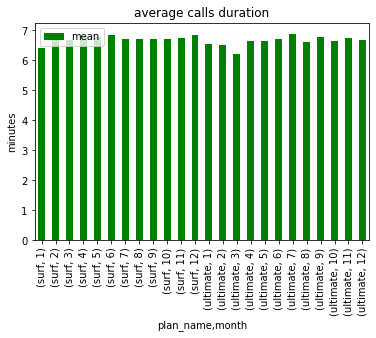

In [109]:
average_duration.plot(kind='bar', color='green', legend=True)
plt.title('average calls duration')
plt.ylabel('minutes')
plt.show()

In [110]:
minutes_needed=calls_merged.groupby(['plan_name','month'])['duration'].sum()

print(minutes_needed)

plan_name  month
surf       1           385.68
           2          2527.66
           3          7152.31
           4         16619.00
           5         29033.10
           6         39499.26
           7         51367.31
           8         62721.48
           9         75852.46
           10        96149.09
           11       113086.75
           12       142297.14
ultimate   1           732.65
           2          2659.03
           3          3428.42
           4          6646.67
           5         11126.28
           6         16441.12
           7         23822.27
           8         28206.51
           9         35542.71
           10        45067.81
           11        53400.65
           12        65384.90
Name: duration, dtype: float64


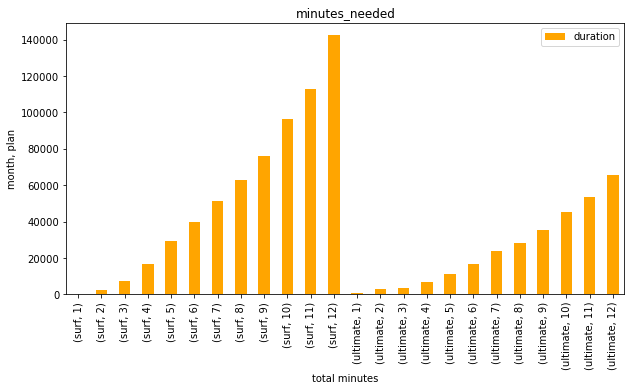

In [111]:

minutes_needed.plot(kind='bar', figsize=(10,5), color='orange', legend=True)
plt.title('minutes_needed')
plt.ylabel('month, plan')
plt.xlabel('total minutes')
plt.show()

calculate mean, variance:

In [112]:

calls_merged.describe()

,index,user_id,duration,duration_ceil,month
count,137735.000000,137735.000000,137735.000000,137735.000000,137735.000000
mean,68867.000000,1247.658046,6.745927,7.146673,9.320797
std,39760.814001,139.416268,5.839241,5.953919,2.412550
min,0.000000,1000.000000,0.000000,0.000000,1.000000
25%,34433.500000,1128.000000,1.290000,2.000000,8.000000
50%,68867.000000,1247.000000,5.980000,6.000000,10.000000
75%,103300.500000,1365.000000,10.690000,11.000000,11.000000
max,137734.000000,1499.000000,37.600000,38.000000,12.000000


In [113]:

calls_surf=calls_merged.query('plan_name=="surf"')
calls_ultimate=calls_merged.query('plan_name=="ultimate"')

In [114]:
calls_surf

,index,id,user_id,call_date,duration,duration_ceil,month,plan_name
16,16,1001_0,1001,2018-09-06,10.06,11,9,surf
17,17,1001_1,1001,2018-10-12,1.00,1,10,surf
18,18,1001_2,1001,2018-10-17,15.83,16,10,surf
19,19,1001_4,1001,2018-12-05,0.00,0,12,surf
20,20,1001_5,1001,2018-12-13,6.27,7,12,surf
...,...,...,...,...,...,...,...,...
137730,137730,1499_199,1499,2018-11-21,8.72,9,11,surf
137731,137731,1499_200,1499,2018-10-20,10.89,11,10,surf
137732,137732,1499_201,1499,2018-09-21,8.12,9,9,surf
137733,137733,1499_202,1499,2018-10-10,0.37,1,10,surf


Defining a general function to applyy to all of the parameters we want to compare:

In [115]:
def users_behaviour(calls_plan):
    
    '''defining a function to apply some stats to the users consumes 
    behaviour: mean, variance, standard deviation and the coefficient of variation'''
    
    calls_plan=calls_surf
    used='duration'
    
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(calls_plan, x=used,color='red')
    plt.title('calls duration for SURF plan')
    mean=calls_plan[used].mean()
    std=calls_plan[used].std()
    var=calls_plan[used].var()
    cv=std/mean
    plt.show()
    
    print("Variance is",var)
    print("Average is",mean)
    print(calls_plan.groupby(['month'])[used].mean())
    if cv>1:
        print("cv=",cv,"Great level of dispersion around the mean")
    else:
        print("cv=",cv,'Distribution centered around average')

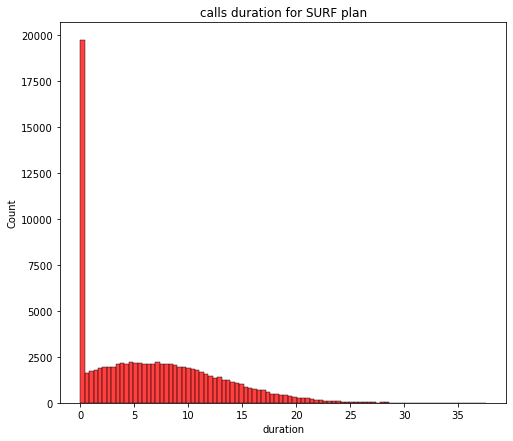

Variance is 34.15697839963775
Average is 6.767263721780397
month
1     6.428000
2     6.906175
3     6.696919
4     6.799918
5     6.769200
6     6.846812
7     6.721710
8     6.726164
9     6.728684
10    6.722302
11    6.759115
12    6.836607
Name: duration, dtype: float64
cv= 0.863627814793868 Distribution centered around average


In [116]:
users_behaviour(calls_surf)

the coefficient of variation (CV) is the ratio of the standard deviation to the mean. The higher the coefficient of variation, the greater the level of dispersion around the mean. 

In [117]:

def users_behaviour(calls_plan):
    
    calls_plan=calls_ultimate
    used='duration'
    
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(calls_plan, x=used, color='red')
    plt.title('calls duration for ULTIMATE plan')
    mean=calls_plan[used].mean()
    std=calls_plan[used].std()
    var=calls_plan[used].var()
    cv=std/mean
    plt.show()
    print("Variance is",var)
    print("Average is",mean)
    print(calls_plan.groupby(['month'])[used].mean())
    if cv>1:
        print("cv=",cv,"Great level of dispersion around the mean")
    else:
        print("cv=",cv,"Distribution centered around average")

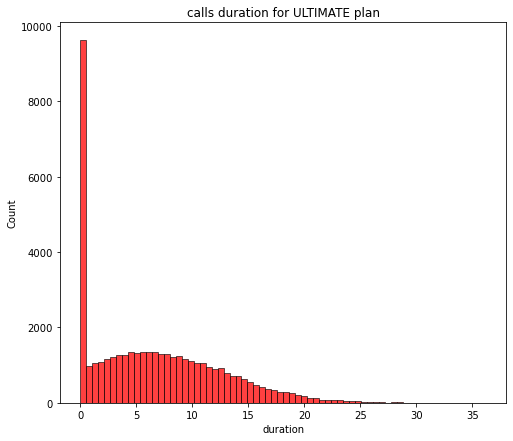

Variance is 33.96457806724801
Average is 6.6999386039266025
month
1     6.541518
2     6.517230
3     6.210906
4     6.659990
5     6.662443
6     6.705188
7     6.879085
8     6.613484
9     6.770040
10    6.665850
11    6.742506
12    6.671929
Name: duration, dtype: float64
cv= 0.8698458362340415 Distribution centered around average


In [118]:
users_behaviour(calls_ultimate)

Plot a boxplot to visualize the distribution of the monthly call duration

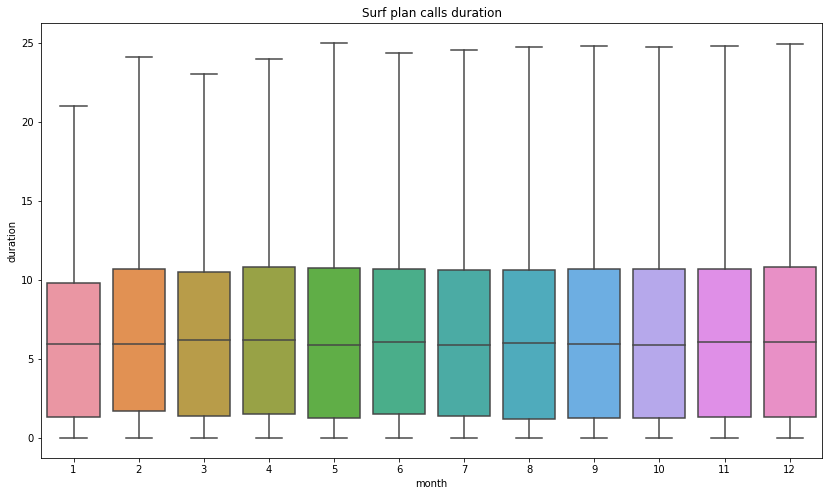

In [119]:

plt.figure(figsize=(14,8))
ax=sns.boxplot(x="month", y="duration", data=calls_surf, showfliers = False).set(title='Surf plan calls duration')

plt.show()

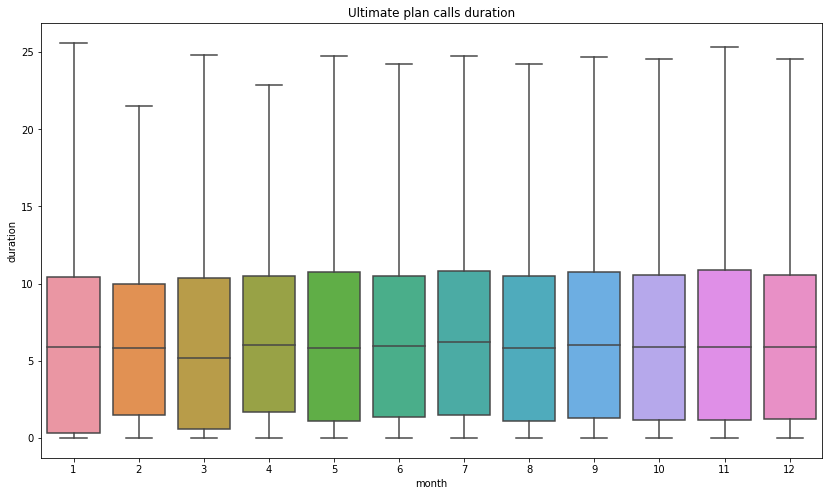

In [120]:
plt.figure(figsize=(14,8))
ax=sns.boxplot(x="month", y="duration", data=calls_ultimate, showfliers = False).set(title='Ultimate plan calls duration')

plt.show()

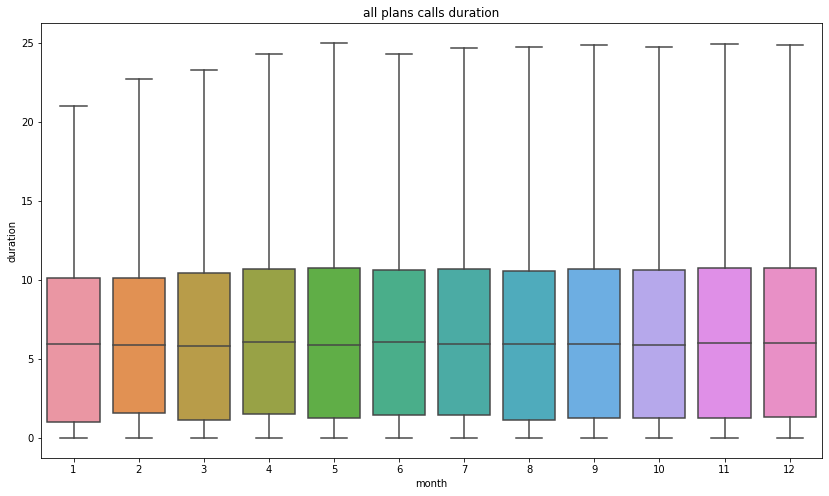

In [121]:
plt.figure(figsize=(14,8))
ax=sns.boxplot(x="month", y="duration", data=calls_merged, showfliers = False).set(title='all plans calls duration')

plt.show()

by comparing the plots, the mean, the variance, the cv and standard deviation we can see that the users behaviour in term of calls is similar, not exactly equal, but similar between the two plans

In [122]:
minutes_needed=minutes_needed.reset_index()

In [123]:
minutes_needed_surf=minutes_needed.query('plan_name=="surf"')


In [124]:
minutes_needed_ultimate=minutes_needed.query('plan_name=="ultimate"')

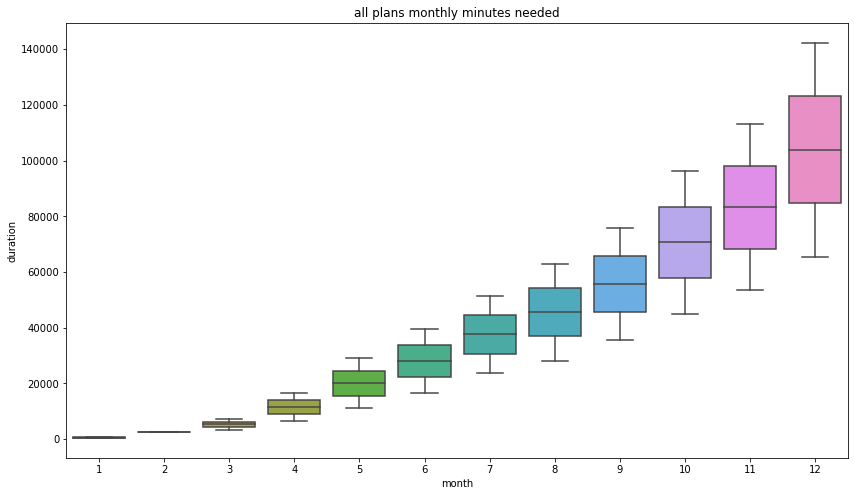

In [125]:
plt.figure(figsize=(14,8))
ax=sns.boxplot(x="month", y="duration", data=minutes_needed, showfliers = False).set(title='all plans monthly minutes needed')

plt.show()

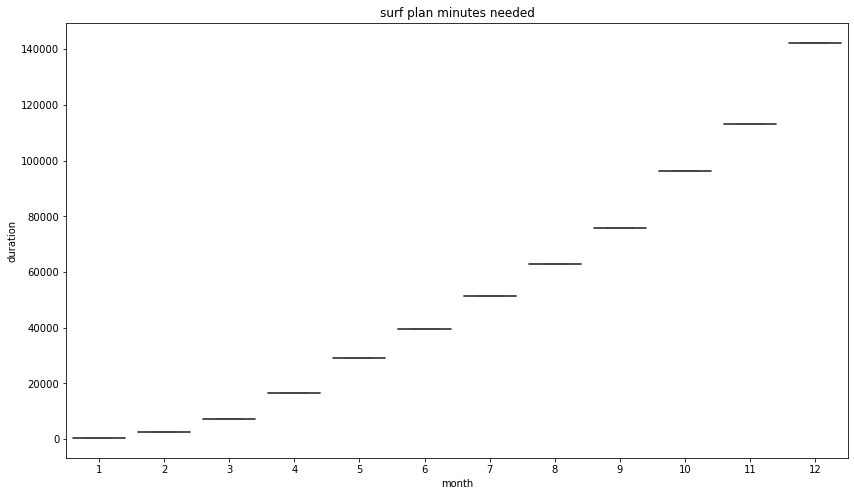

In [126]:
plt.figure(figsize=(14,8))
ax=sns.boxplot(x="month", y="duration", data=minutes_needed_surf, showfliers = False).set(title='surf plan minutes needed')

plt.show()

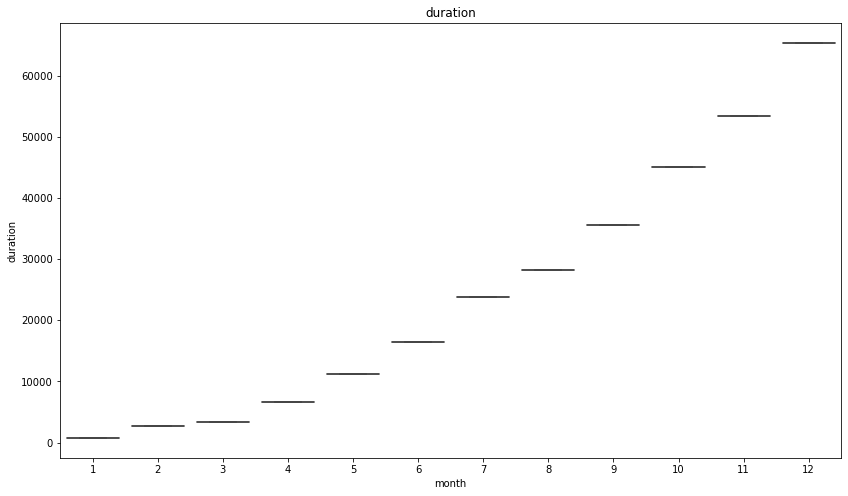

In [127]:
plt.figure(figsize=(14,8))
ax=sns.boxplot(x="month", y="duration", data=minutes_needed_ultimate, showfliers = False).set(title='duration')

plt.show()

both plans show similar distributuion

### Messages

Compare the number of messages users of each plan tend to send each month

In [128]:

messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  category      
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(1), object(1)
memory usage: 1.9+ MB


In [129]:
messages_merged= pd.merge(messages, users_filtered , how='left', on='user_id')


In [130]:
print(messages_merged)

             id  user_id message_date  month plan_name
0      1000_125     1000   2018-12-27     12  ultimate
1      1000_160     1000   2018-12-31     12  ultimate
2      1000_223     1000   2018-12-31     12  ultimate
3      1000_251     1000   2018-12-27     12  ultimate
4      1000_255     1000   2018-12-26     12  ultimate
...         ...      ...          ...    ...       ...
76046  1497_526     1268   2018-12-24     12      surf
76047  1497_536     1268   2018-12-24     12      surf
76048  1497_547     1268   2018-12-31     12      surf
76049  1497_558     1268   2018-12-24     12      surf
76050  1497_613     1268   2018-12-23     12      surf

[76051 rows x 5 columns]


In [131]:
messages_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76051 entries, 0 to 76050
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
 4   plan_name     76051 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 3.5+ MB


In [132]:
g=messages_merged.groupby(['plan_name', 'month', 'user_id'])['message_date'].agg(message_count='count').reset_index()

In [133]:
print(g)

     plan_name  month  user_id  message_count
0         surf      1     1048              6
1         surf      1     1049             23
2         surf      1     1119             13
3         surf      1     1120             10
4         surf      1     1203              8
...        ...    ...      ...            ...
1892  ultimate     12     1249            170
1893  ultimate     12     1250             37
1894  ultimate     12     1253             11
1895  ultimate     12     1255             62
1896  ultimate     12     1264            228

[1897 rows x 4 columns]


In [134]:
messages_surf=g.query('plan_name=="surf"')


In [135]:
messages_ultimate=g.query('plan_name=="ultimate"')

In [136]:
def users_behaviour(messages_plan):
    
    messages_plan=messages_ultimate
    used='message_count'
    
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(messages_plan, x=used, color='purple')
    plt.title('messages sent Ultimate plan')
    mean=messages_plan[used].mean()
    std=messages_plan[used].std()
    var=messages_plan[used].var()
    cv=std/mean
    plt.show()
    print("Variance is",var)
    print("Average is",mean)
    print("average messages sent", 
          messages_plan.groupby(['month'])[used].mean())
    if cv>1:
        print("cv=",cv,"Great level of dispersion around the mean")
    else:
        print("cv=",cv,"Distribution centered around average")

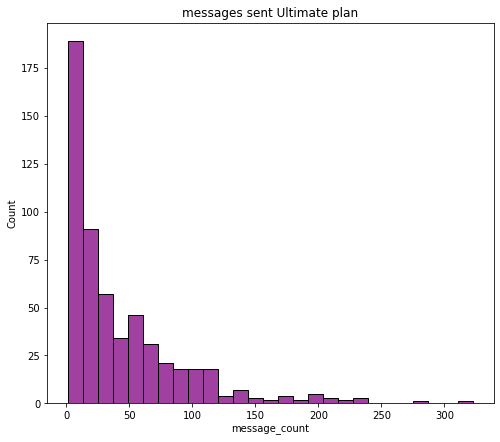

Variance is 2414.211982494249
Average is 43.448214285714286
average messages sent month
1      5.000000
2     13.000000
3     15.800000
4     11.642857
5     21.282051
6     21.846154
7     27.241379
8     35.890625
9     41.557143
10    49.493333
11    57.423077
12    85.525000
Name: message_count, dtype: float64
cv= 1.1308780349433256 Great level of dispersion around the mean


In [137]:
users_behaviour(messages_ultimate)

In [138]:
def users_behaviour(messages_plan):
    
    messages_plan=messages_surf
    used='message_count'
    
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(messages_plan, x=used, color='purple')
    plt.title('messages sent surf plan')
    mean=messages_plan[used].mean()
    std=messages_plan[used].std()
    var=messages_plan[used].var()
    cv=std/mean
    plt.show()
    print("Variance is",var)
    print("Average is",mean)
    print("average messages sent", 
          messages_plan.groupby(['month'])[used].mean())
    if cv>1:
        print("cv=",cv,"Great level of dispersion around the mean")
    else:
        print("cv=",cv,"Distribution centered around average")

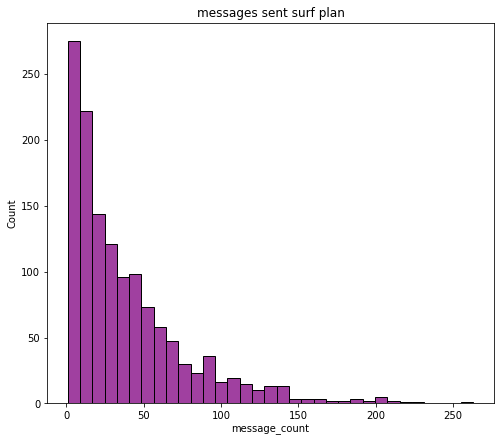

Variance is 1502.0877030531328
Average is 38.68362004487659
average messages sent month
1      9.125000
2     11.500000
3     15.034483
4     14.594203
5     20.103093
6     21.404762
7     26.289855
8     33.097403
9     37.164706
10    48.787356
11    53.870787
12    69.482955
Name: message_count, dtype: float64
cv= 1.0018911409053162 Great level of dispersion around the mean


In [139]:
users_behaviour(messages_surf)

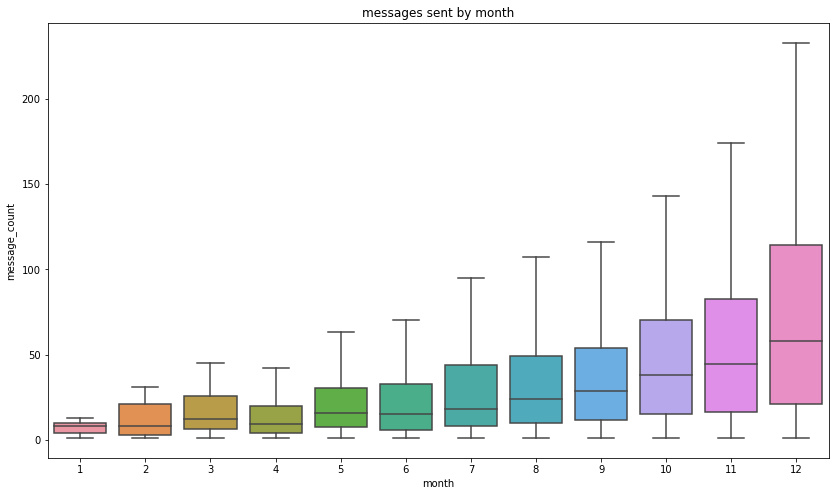

In [140]:
plt.figure(figsize=(14,8))
ax=sns.boxplot(x="month", y="message_count", data=g, showfliers = False).set(title='messages sent by month')

plt.show()

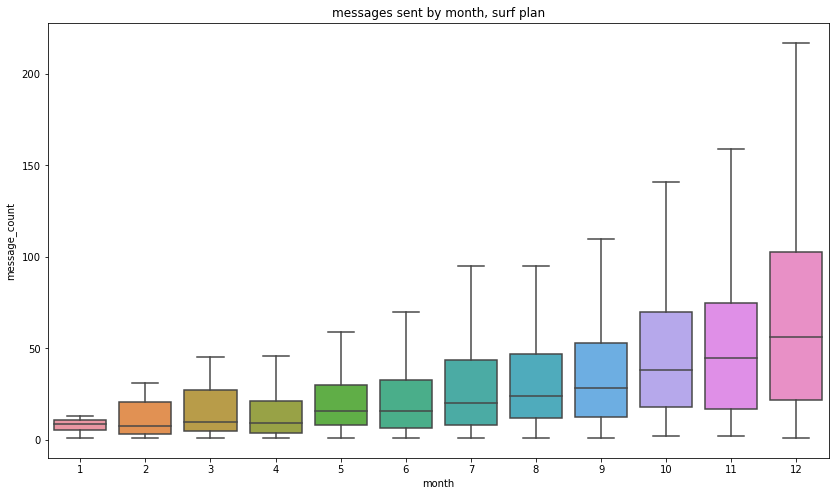

In [141]:
plt.figure(figsize=(14,8))
ax=sns.boxplot(x="month", y="message_count", data=messages_surf, showfliers = False).set(title='messages sent by month, surf plan')

plt.show()

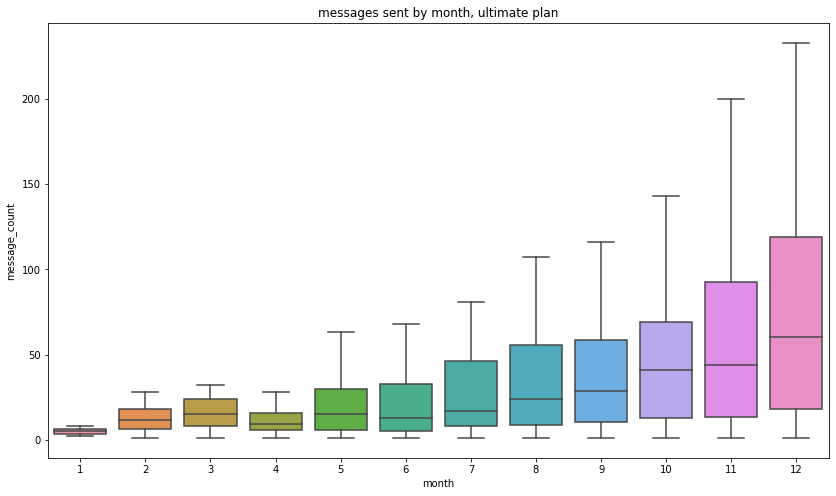

In [142]:
plt.figure(figsize=(14,8))
ax=sns.boxplot(x="month", y="message_count", data=messages_ultimate, showfliers = False).set(title='messages sent by month, ultimate plan')

plt.show()

Again, we notice a similar distribution and a similar behaviour in number of messages sent

***Compare the amount of internet traffic consumed by users per plan***


### Internet

In [143]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  category      
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
 5   gb_used       104825 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 4.2+ MB


In [144]:
internet_merged=messages_merged= pd.merge(internet, users_filtered , how='left', on='user_id')

In [145]:
internet_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104825 entries, 0 to 104824
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
 5   gb_used       104825 non-null  float64       
 6   plan_name     104825 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 6.4+ MB


In [146]:
i_g=internet_merged.groupby(['user_id','plan_name','month'])['gb_used'].sum().reset_index()

In [147]:
display(i_g)

,user_id,plan_name,month,gb_used
0,1000,ultimate,12,1.90147
1,1001,surf,8,6.91915
2,1001,surf,9,13.31482
3,1001,surf,10,22.33049
4,1001,surf,11,18.50430
...,...,...,...,...
2272,1498,surf,12,23.13769
2273,1499,surf,9,12.98476
2274,1499,surf,10,19.49243
2275,1499,surf,11,16.81383


In [148]:
internet_surf=i_g.query('plan_name=="surf"')
internet_ultimate=i_g.query('plan_name=="ultimate"')

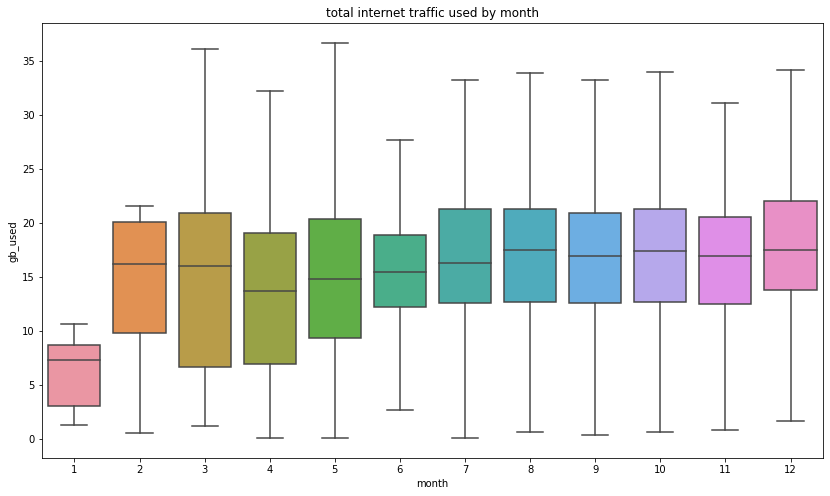

In [149]:
plt.figure(figsize=(14,8))
ax=sns.boxplot(x="month", y="gb_used", data=i_g, showfliers = False).set(title='total internet traffic used by month')

plt.show()

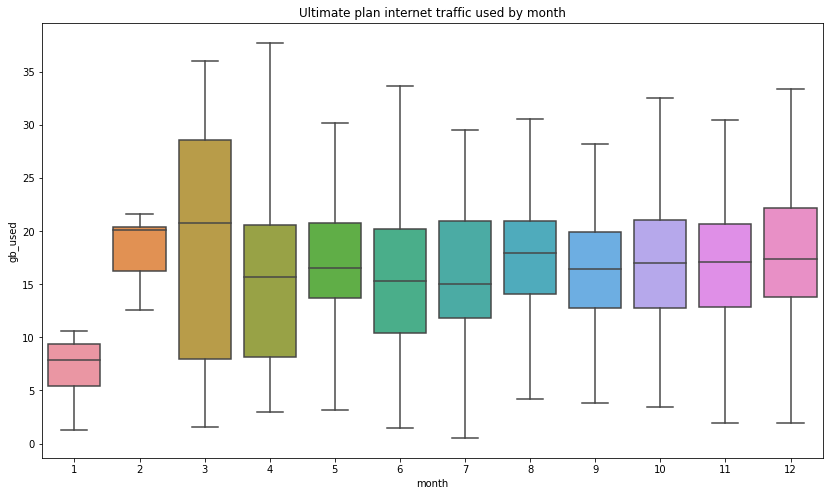

In [150]:
plt.figure(figsize=(14,8))
ax=sns.boxplot(x="month", y="gb_used", data=internet_ultimate, showfliers = False).set(title='Ultimate plan internet traffic used by month')

plt.show()

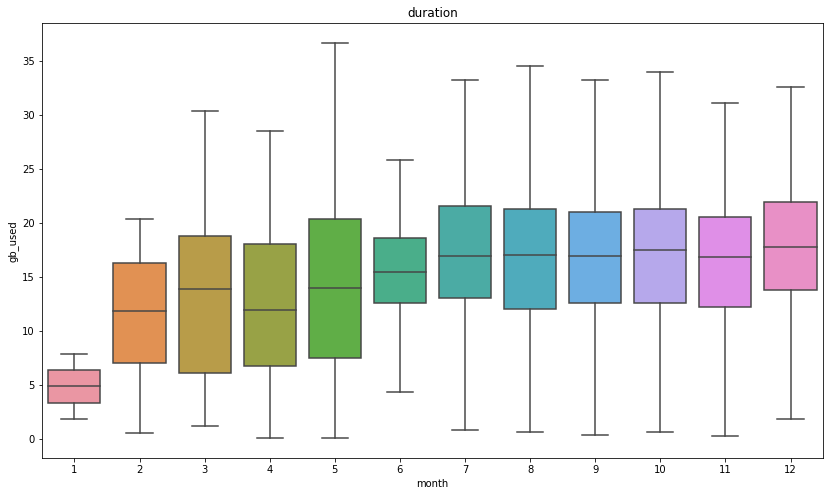

In [151]:
plt.figure(figsize=(14,8))
ax=sns.boxplot(x="month", y="gb_used", data=internet_surf, showfliers = False).set(title='duration')

plt.show()

In [152]:
def users_behaviour(internet_plan):
    
    internet_plan=internet_surf
    used='gb_used'
    
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(internet_plan, x=used, color='blue')
    plt.title('traffic used surf plan')
    mean=internet_plan[used].mean() 
    std=internet_plan[used].std()
    var=internet_plan[used].var()
    cv=std/mean
    plt.show()
    print("Variance is",var)
    print("Average is",mean)
    print("average gb used", 
          internet_plan.groupby(['month'])[used].mean())
    if cv>1:
        print("cv=",cv,"Great level of dispersion around the mean")
    else:
        print("cv=",cv,"Distribution centered around average")


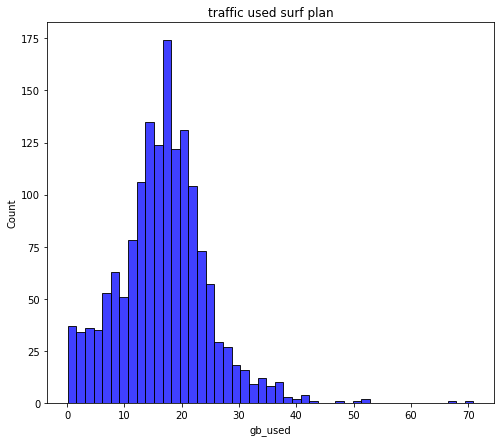

Variance is 62.16822574692846
Average is 16.71770213735559
average gb used month
1      4.874860
2     12.178843
3     13.345440
4     12.228779
5     14.119728
6     15.623667
7     16.923464
8     17.112224
9     16.677397
10    17.533275
11    16.455548
12    18.189670
Name: gb_used, dtype: float64
cv= 0.4716367667341242 Distribution centered around average


In [153]:
users_behaviour(internet_surf)

In [154]:
def users_behaviour(internet_plan):
    
    internet_plan=internet_ultimate
    used='gb_used'
    
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(internet_plan, x=used, color='blue')
    plt.title('traffic used Ultimate plan')
    mean=internet_plan[used].mean()
    std=internet_plan[used].std()
    var=internet_plan[used].var()
    cv=std/mean
    plt.show()
    print("Variance is",var)
    print("Average is",mean)
    print("average gb used", 
          internet_plan.groupby(['month'])[used].mean())
    if cv>1:
        print("cv=",cv,"Great level of dispersion around the mean")
    else:
        print("cv=",cv,"Distribution centered around average")
   

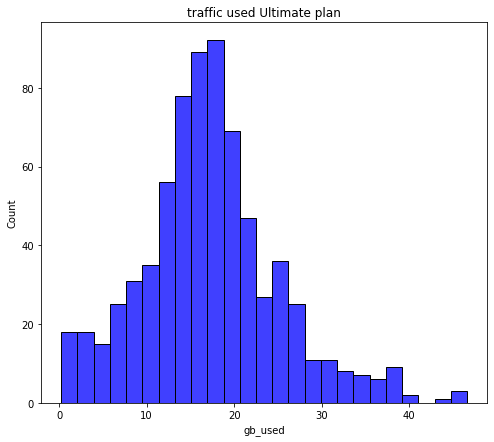

Variance is 61.324847980956235
Average is 17.238642253129356
average gb used month
1      6.918093
2     17.128809
3     18.321518
4     16.121655
5     16.624482
6     15.337921
7     16.344744
8     17.814720
9     16.969870
10    17.780292
11    17.033685
12    18.323192
Name: gb_used, dtype: float64
cv= 0.4542711779953781 Distribution centered around average


In [155]:
users_behaviour(internet_ultimate)

Similar distribution also for the internet traffic

## Revenue

Likewise we studied the user behaviour, statistically describe the revenue between the plans:

In [156]:
revenues.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5772 entries, (1000, 1) to (1499, 12)
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   plan_name        5772 non-null   object 
 1   usd_monthly_pay  5772 non-null   int64  
 2   extra_internet   5772 non-null   float64
 3   extra_calls      5772 non-null   float64
 4   extra_messages   5772 non-null   float64
 5   monthly_revenue  5772 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 448.0+ KB


In [157]:
revenues=revenues.reset_index()

In [158]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan_name,churn_date,reg_month
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,unknown,12
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,unknown,8
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,unknown,10
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,unknown,1
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,unknown,5


In [159]:
revenues_merged= pd.merge(revenues, users , how='left', on=['user_id','plan_name'])

In [160]:
revenues_merged.T

,0,1,2,3,4,5,6,7,8,9,...,5762,5763,5764,5765,5766,5767,5768,5769,5770,5771
user_id,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1499,1499,1499,1499,1499,1499,1499,1499,1499,1499
month,1,2,3,4,5,6,7,8,9,10,...,3,4,5,6,7,8,9,10,11,12
plan_name,ultimate,ultimate,ultimate,ultimate,ultimate,ultimate,ultimate,ultimate,ultimate,ultimate,...,surf,surf,surf,surf,surf,surf,surf,surf,surf,surf
usd_monthly_pay,70,70,70,70,70,70,70,70,70,70,...,20,20,20,20,20,20,20,20,20,20
extra_internet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,20.0,80.0
extra_calls,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
extra_messages,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
monthly_revenue,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,70.0,40.0,100.0
first_name,anamaria,anamaria,anamaria,anamaria,anamaria,anamaria,anamaria,anamaria,anamaria,anamaria,...,shena,shena,shena,shena,shena,shena,shena,shena,shena,shena
last_name,bauer,bauer,bauer,bauer,bauer,bauer,bauer,bauer,bauer,bauer,...,dickson,dickson,dickson,dickson,dickson,dickson,dickson,dickson,dickson,dickson


In [161]:
revenues=revenues_merged.drop(columns=['first_name', 'last_name', 'age','reg_date', 'churn_date'])

In [162]:
revenues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5772 entries, 0 to 5771
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          5772 non-null   int64  
 1   month            5772 non-null   int64  
 2   plan_name        5772 non-null   object 
 3   usd_monthly_pay  5772 non-null   int64  
 4   extra_internet   5772 non-null   float64
 5   extra_calls      5772 non-null   float64
 6   extra_messages   5772 non-null   float64
 7   monthly_revenue  5772 non-null   float64
 8   city             5772 non-null   object 
 9   reg_month        5772 non-null   int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 625.1+ KB


In [163]:
revenues_surf=revenues.query('plan_name=="surf"')


In [164]:
revenues_surf.head(15)

,user_id,month,plan_name,usd_monthly_pay,extra_internet,extra_calls,extra_messages,monthly_revenue,city,reg_month
12,1001,1,surf,20,0.0,0.0,0.00,20.00,"seattle-tacoma-bellevue, wa msa",8
13,1001,2,surf,20,0.0,0.0,0.00,20.00,"seattle-tacoma-bellevue, wa msa",8
14,1001,3,surf,20,0.0,0.0,0.00,20.00,"seattle-tacoma-bellevue, wa msa",8
15,1001,4,surf,20,0.0,0.0,0.00,20.00,"seattle-tacoma-bellevue, wa msa",8
16,1001,5,surf,20,0.0,0.0,0.00,20.00,"seattle-tacoma-bellevue, wa msa",8
17,1001,6,surf,20,0.0,0.0,0.00,20.00,"seattle-tacoma-bellevue, wa msa",8
18,1001,7,surf,20,0.0,0.0,0.00,20.00,"seattle-tacoma-bellevue, wa msa",8
19,1001,8,surf,20,0.0,0.0,0.00,20.00,"seattle-tacoma-bellevue, wa msa",8
20,1001,9,surf,20,0.0,0.0,0.00,20.00,"seattle-tacoma-bellevue, wa msa",8
21,1001,10,surf,20,80.0,0.0,0.33,100.33,"seattle-tacoma-bellevue, wa msa",8


In [165]:
def revenues_stat(plan):
    
    plan=revenues_surf
    revenue='monthly_revenue'
    
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(plan, x=revenue, color='orange')
    mean=plan[revenue].mean()
    std=plan[revenue].std()
    var=plan[revenue].var()
    cv=std/mean
    plt.show()
    print("Variance is",var)
    print("Average is",mean)
    print("average monthly revenue", 
          plan.groupby(['month'])[revenue].mean())
    if cv>1:
        print("cv=",cv,"Great level of dispersion around the mean")
    else:
        print("cv=",cv,"Distribution centered around average")
   

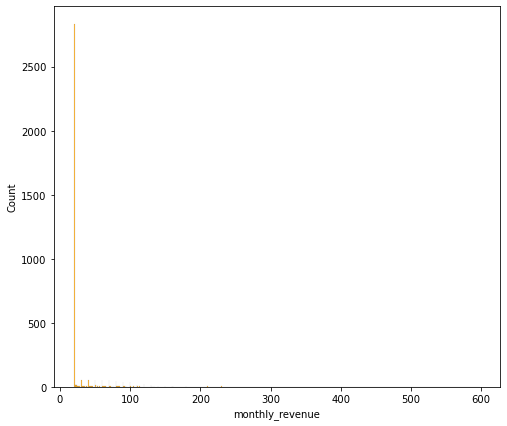

Variance is 1661.771613303156
Average is 37.02026329243353
average monthly revenue month
1     20.000000
2     20.488742
3     21.982393
4     23.383190
5     27.082914
6     29.293620
7     37.073344
8     43.238190
9     43.392699
10    53.847362
11    54.313282
12    70.147423
Name: monthly_revenue, dtype: float64
cv= 1.1011491929275365 Great level of dispersion around the mean


In [166]:
revenues_stat(revenues_surf)

In [167]:
revenues_ultimate=revenues.query('plan_name=="ultimate"')

In [168]:
revenues_ultimate

,user_id,month,plan_name,usd_monthly_pay,extra_internet,extra_calls,extra_messages,monthly_revenue,city,reg_month
0,1000,1,ultimate,70,0.0,0.0,0.0,70.0,"atlanta-sandy springs-roswell, ga msa",12
1,1000,2,ultimate,70,0.0,0.0,0.0,70.0,"atlanta-sandy springs-roswell, ga msa",12
2,1000,3,ultimate,70,0.0,0.0,0.0,70.0,"atlanta-sandy springs-roswell, ga msa",12
3,1000,4,ultimate,70,0.0,0.0,0.0,70.0,"atlanta-sandy springs-roswell, ga msa",12
4,1000,5,ultimate,70,0.0,0.0,0.0,70.0,"atlanta-sandy springs-roswell, ga msa",12
...,...,...,...,...,...,...,...,...,...,...
5743,1497,8,ultimate,70,0.0,0.0,0.0,70.0,"los angeles-long beach-anaheim, ca msa",12
5744,1497,9,ultimate,70,0.0,0.0,0.0,70.0,"los angeles-long beach-anaheim, ca msa",12
5745,1497,10,ultimate,70,0.0,0.0,0.0,70.0,"los angeles-long beach-anaheim, ca msa",12
5746,1497,11,ultimate,70,0.0,0.0,0.0,70.0,"los angeles-long beach-anaheim, ca msa",12


In [169]:
def revenues_stat(plan):
    
    plan=revenues_ultimate
    revenue='monthly_revenue'
    
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(plan, x=revenue,color='orange')
    mean=plan[revenue].mean()
    std=plan[revenue].std()
    var=plan[revenue].var()
    cv=std/mean
    plt.show()
    print("Variance is",var)
    print("Average is",mean)
    print("average monthly revenue Ultimate", 
          plan.groupby(['month'])[revenue].mean())
    if cv>1:
        print("cv=",cv,"Great level of dispersion around the mean")
    else:
        print("cv=",cv,"Distribution centered around average")

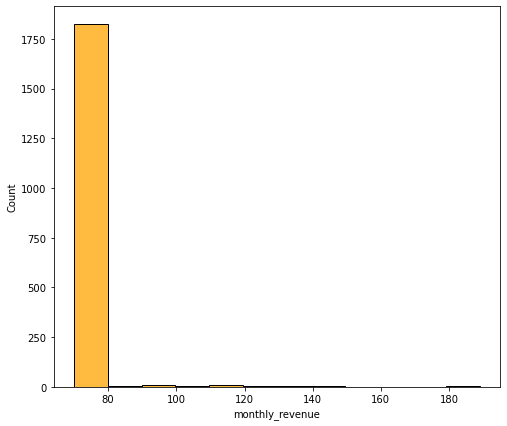

Variance is 62.6144507684219
Average is 71.01989247311828
average monthly revenue Ultimate month
1     70.000000
2     70.000000
3     70.451613
4     70.496774
5     70.180645
6     70.541935
7     70.812903
8     71.580645
9     71.309677
10    71.806452
11    71.625806
12    73.432258
Name: monthly_revenue, dtype: float64
cv= 0.11141849228794029 Distribution centered around average


In [170]:
revenues_stat(revenues_ultimate)

We can observe that the revenues from the two plans show a different distribution. In average, the customers of the ultimate plan tend to be less charged compared to the custumers of Surf Plan.Ttoward the end of the year we can see the the revenues of the surf plan doubling and arriving to the average of 66 dollars for the month of December. In general we can see that the clients using the Ultimate plan, have enough minutes, traffic and messages, while the surf plann tend to be exceeded.

Let's compare the revenues users from users in NY-NJ area and other areas:

In [171]:
revenues.city.unique()

array(['atlanta-sandy springs-roswell, ga msa',
       'seattle-tacoma-bellevue, wa msa',
       'las vegas-henderson-paradise, nv msa', 'tulsa, ok msa',
       'dallas-fort worth-arlington, tx msa',
       'san francisco-oakland-berkeley, ca msa',
       'grand rapids-kentwood, mi msa',
       'orlando-kissimmee-sanford, fl msa',
       'san jose-sunnyvale-santa clara, ca msa',
       'cleveland-elyria, oh msa',
       'chicago-naperville-elgin, il-in-wi msa', 'knoxville, tn msa',
       'new york-newark-jersey city, ny-nj-pa msa', 'pittsburgh, pa msa',
       'fresno, ca msa',
       'washington-arlington-alexandria, dc-va-md-wv msa',
       'indianapolis-carmel-anderson, in msa', 'jacksonville, fl msa',
       'los angeles-long beach-anaheim, ca msa',
       'omaha-council bluffs, ne-ia msa',
       'houston-the woodlands-sugar land, tx msa',
       'philadelphia-camden-wilmington, pa-nj-de-md msa',
       'tampa-st. petersburg-clearwater, fl msa',
       'birmingham-hoover, al msa'

In [172]:
revenues_ny_nj=revenues.query('city=="new york-newark-jersey city, ny-nj-pa msa"')


In [173]:
revenues_ny_nj.sample(5)

,user_id,month,plan_name,usd_monthly_pay,extra_internet,extra_calls,extra_messages,monthly_revenue,city,reg_month
1603,1141,8,surf,20,20.0,5.37,1.2,46.57,"new york-newark-jersey city, ny-nj-pa msa",6
5012,1434,9,surf,20,10.0,0.00,0.0,30.00,"new york-newark-jersey city, ny-nj-pa msa",3
1622,1144,3,ultimate,70,0.0,0.00,0.0,70.00,"new york-newark-jersey city, ny-nj-pa msa",4
4624,1402,5,surf,20,0.0,0.00,0.0,20.00,"new york-newark-jersey city, ny-nj-pa msa",6
3379,1294,8,surf,20,0.0,0.00,0.0,20.00,"new york-newark-jersey city, ny-nj-pa msa",4


In [174]:
def revenues_stat(plan):
    
    plan=revenues_ny_nj
    revenue='monthly_revenue'
    
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(plan, x=revenue, color='yellow')
    mean=plan[revenue].mean()
    std=plan[revenue].std()
    var=plan[revenue].var()
    cv=std/mean
    plt.show()
    print("Variance is",var)
    print("Average is",mean)
    print("average monthly revenue Ny-Nj", 
          plan.groupby(['month'])[revenue].mean())
    if cv>1:
        print("cv=",cv,"Great level of dispersion around the mean")
    else:
        print("cv=",cv,"Distribution centered around average")

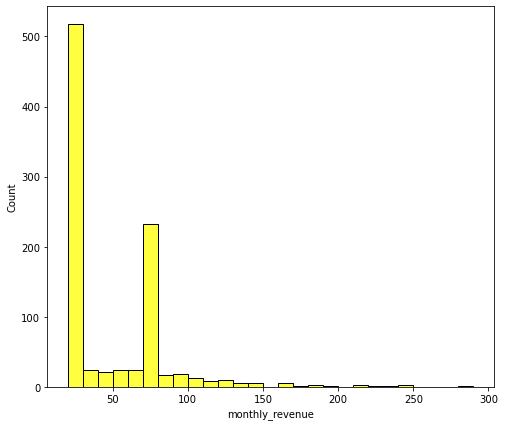

Variance is 1268.2425029585456
Average is 45.34220085470085
average monthly revenue Ny-Nj month
1     32.179487
2     32.820513
3     33.933846
4     35.457308
5     38.641410
6     39.107308
7     44.015000
8     49.879872
9     52.299615
10    59.874103
11    61.017949
12    64.880000
Name: monthly_revenue, dtype: float64
cv= 0.7854138501489681 Distribution centered around average


In [175]:
revenues_stat(revenues_ny_nj)

In [176]:
revenues_other_city=revenues.query('city!="new york-newark-jersey city, ny-nj-pa msa"')


In [177]:
def revenues_stat(plan):
    
    plan=revenues_other_city
    revenue='monthly_revenue'
    
    fig, ax = plt.subplots(figsize=(8,7))
    ax = sns.histplot(plan, x=revenue, color='yellow')
    mean=plan[revenue].mean()
    std=plan[revenue].std()
    var=plan[revenue].var()
    cv=std/mean
    plt.show()
    print("Variance is",var)
    print("Average is",mean)
    print("average monthly other_city", 
          plan.groupby(['month'])[revenue].mean())
    if cv>1:
        print("cv=",cv,"Great level of dispersion around the mean")
    else:
        print("cv=",cv,"Distribution centered around average")

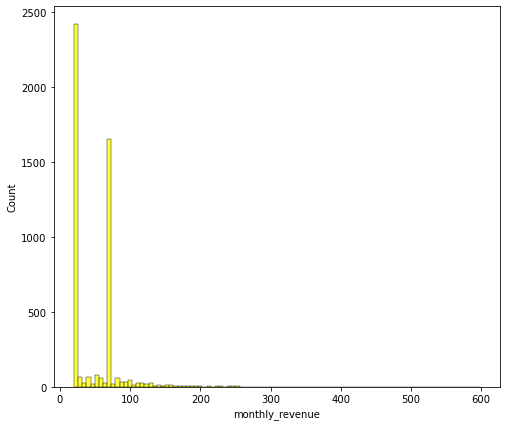

Variance is 1422.8084854471188
Average is 48.486346153846114
average monthly other_city month
1     36.873449
2     37.144739
3     38.311216
4     39.166873
5     41.421836
6     43.258933
7     48.706551
8     52.853648
9     52.406079
10    59.588238
11    59.674268
12    72.430323
Name: monthly_revenue, dtype: float64
cv= 0.7779537267749842 Distribution centered around average


In [178]:
revenues_stat(revenues_other_city)

In [179]:
revenues_other_city.sample(5)

,user_id,month,plan_name,usd_monthly_pay,extra_internet,extra_calls,extra_messages,monthly_revenue,city,reg_month
3408,1297,1,surf,20,0.0,0.00,0.0,20.00,"los angeles-long beach-anaheim, ca msa",8
1411,1122,8,surf,20,150.0,0.03,0.3,170.33,"miami-fort lauderdale-west palm beach, fl msa",3
884,1074,9,ultimate,70,0.0,0.00,0.0,70.00,"knoxville, tn msa",11
738,1062,7,ultimate,70,0.0,0.00,0.0,70.00,"san antonio-new braunfels, tx msa",2
4519,1393,8,surf,20,0.0,0.00,0.0,20.00,"knoxville, tn msa",10


It seems that the other areas bring in a slightly higher revenue.

## Test statistical hypotheses

*Test the hypotheses:*
* The average revenue from users of Ultimate and Surf calling plans differs.
* The average revenue from users in NY-NJ area is different from that of the users from other regions.

In order to test these two hypoteses, it's needeג to formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value

The null hypothesis in statistics states that there is no difference between groups or no relationship between variables

The null hypotesis, H0 formulated in this analisys, is that ***
* ***"the average profit of Ultimate plan equals the average profits of the surf plan" and that "the average profits from the users in ny_nj equals of the users from other regions"***

If the sample provides enough evidence against the claim that there’s no effect in the population (p ≤ α), then we can reject the null hypothesis. Otherwise, we fail to reject the null hypothesis.

Although “fail to reject” may sound awkward, it’s the only wording that statisticians accept.


The alternative hypotheses are:

* The average revenue from users of Ultimate and Surf calling plans differs.
* The average revenue from users in NY-NJ area is different from that of the users from other regions.





to test the hipostheses, I am going to use a t-test: The indepentent T-test is a parametric test used to test for a statistically significant difference in the means between 2 groups. As with all parametric tests, there are certain conditions that need to be met in order for the test results to be considered reliable.

Parametric test assumptions:

Population distributions are normal
Samples have equal variances
The two samples are independent

H0 => µ1 = µ2 (population mean of dataset1 is equal to dataset2)

HA => µ1 ≠µ2 (population mean of dataset1 is different from dataset2)

to interpret the reults of the test, we need to choose a value for alpha, to compare the P value.

The alpha value cannot be determined in the sense that there were a formula to calculate it. Instead, it is arbitrarily chosen, ideally before the study is conducted.

The value alpha = 0.05 is a common choice that goes back to a suggestion by Ronald Fisher in his influential book Statistical Methods for Research Workers (first published in 1925). The only particular reason for this value is that if the test statistic has a normal distribution under the null hypothesis, then for a two-tailed test with alpha = 0.05 the critical values of the test statistic will be its mean plus/minus 2 (more exactly, 1.96) times its standard deviation.

In fact, you don't need alpha when you calculate the p value, because you can just publish the p value and then every reader can decide whether to consider it low enough for any given purpose or not.If the p-value is less than alpha, we reject the hypothesis

i choose a value of alpha=0.05

Test the hypothesis that the average revenue from users subscribed on Surf plan is different from that of the users from the Ultimate plan.

In [180]:
# Test the hypotheses

alpha = 0.05  # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(revenues_surf['monthly_revenue'],revenues_ultimate['monthly_revenue'])

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 


p-value:  9.166050070160189e-252
We reject the null hypothesis


Test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.

In [181]:
# Test the hypotheses
results = st.ttest_ind(revenues_ny_nj['monthly_revenue'],revenues_other_city['monthly_revenue'])

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 



p-value:  0.01855248860463737
We reject the null hypothesis


## General conclusion

The Ultimate Plan and the Surf plan generate a difference in the revenue: the Ultimate plan is more expensive, but what it offers is generally enough to the clients, so they don't really get charged much for extra calls, internet and messages. the surf plan has a cheaper default, but it's client tend to exceed the plan, since they have similar behaviour of the Ultimate clients, and generate additional extra revenues.


The areas of NY-NJ tend to generate slightly less revenues.